In [1]:
import torch
import esm

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
    ("proteun4", "AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS")
]

In [2]:
print(alphabet)


In [3]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)

In [4]:
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

In [5]:
token_representations[0].shape

torch.Size([288, 1280])

In [6]:
# Generate per-sequence representations via averaging
# NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
sequence_representations = []
for i, (_, seq) in enumerate(data):
    sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))
    print(token_representations[i].shape)

torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])
torch.Size([288, 1280])


## Attention representation

We may have more information if we can do the regression from the attention matrix.
The issue is that the size of the attention matrix depends on the length of the sequence. It could be that we could use the entire length that has zeros but then the regression model may get biased toward that.

How to go for a varying length attention representation to a regression??

torch.Size([286, 286])


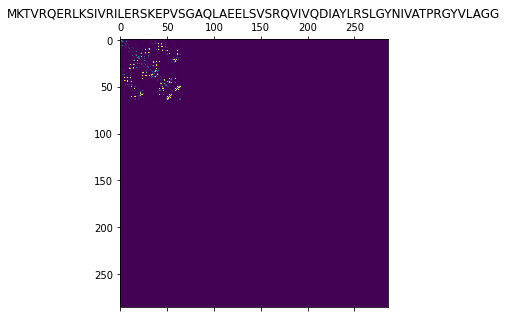

torch.Size([286, 286])


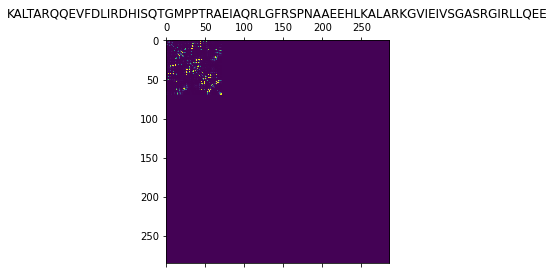

torch.Size([286, 286])


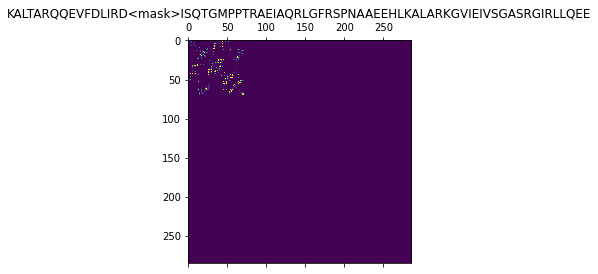

torch.Size([286, 286])


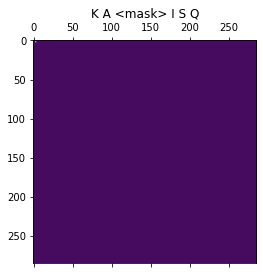

torch.Size([286, 286])


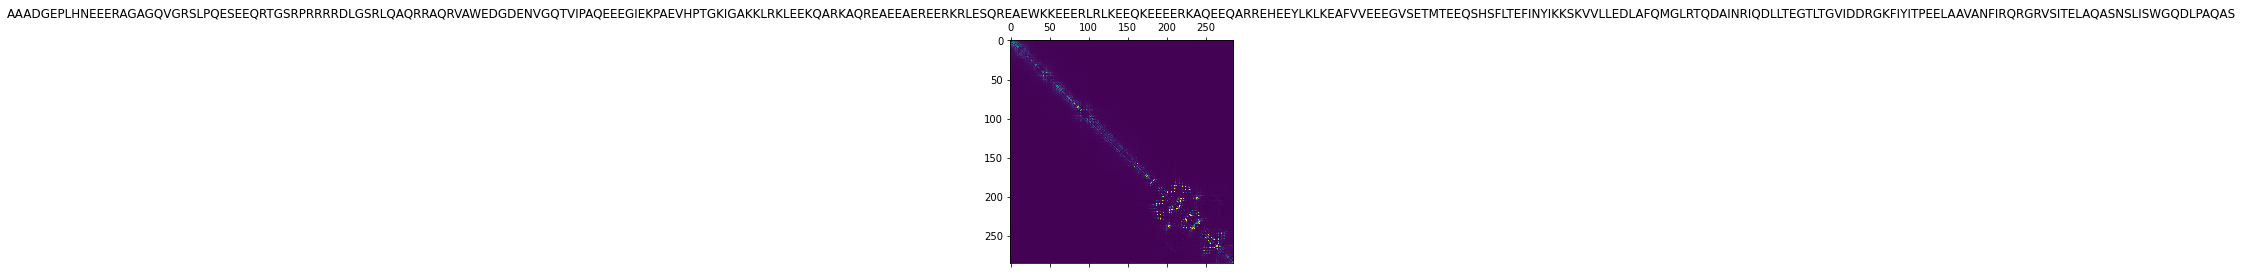

In [7]:
# Look at the unsupervised self-attention map contact predictions
import matplotlib.pyplot as plt
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    #plt.matshow(attention_contacts[: len(seq), : len(seq)])
    print(attention_contacts.shape)
    plt.matshow(attention_contacts[: , : ])
    plt.title(seq)
    plt.show()

In [8]:
print(results.keys())

dict_keys(['logits', 'representations', 'attentions', 'contacts'])


In [9]:
logits = results['representations']

In [10]:
print(logits[33].shape)

torch.Size([5, 288, 1280])


In [11]:
print(model)

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [12]:
print(alphabet)

## Sequence embedding

The paper suggest to average all the hidden states and come to an embedding for the sequence. That is definately the first thing that we can try, but we may be losing some important information. 

We first try this.

In [13]:
newdata = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
]

In [14]:
batch_labels, batch_strs, batch_tokens = batch_converter(newdata)

In [15]:
with torch.no_grad():
    newresults = model(batch_tokens, repr_layers=[32], return_contacts=True)
    
token_representations = newresults["representations"][32]

In [16]:
token_representations.shape

torch.Size([1, 67, 1280])

In [17]:
sequence_representations[0]

tensor([ 0.0614, -0.0687,  0.0430,  ..., -0.1642, -0.0678,  0.0446])

In [18]:
import pandas as pd

In [19]:
df_train = pd.read_csv("./proteindata/train.csv", index_col="seq_id")
df_train_updates = pd.read_csv("./proteindata/train_updates_20220929.csv", index_col="seq_id")

In [20]:
df_train.shape

(31390, 4)

In [21]:
all_features_nan = df_train_updates.isnull().all("columns")

In [22]:
drop_indices = df_train_updates[all_features_nan].index

In [23]:
drop_indices

Int64Index([   69,    70,    71,    72,    73,    74,    75,    76,    77,
               78,
            ...
            29682, 29787, 29788, 29852, 29853, 30738, 30739, 30740, 30741,
            30742],
           dtype='int64', name='seq_id', length=2409)

In [24]:
df_train = df_train.drop(index=drop_indices)

In [25]:
df_train.shape

(28981, 4)

In [26]:
swap_ph_tm_indices = df_train_updates[~all_features_nan].index
df_train.loc[swap_ph_tm_indices, ["pH", "tm"]] = df_train_updates.loc[swap_ph_tm_indices, ["pH", "tm"]]

In [27]:
data = df_train

In [28]:
data.shape

(28981, 4)

In [29]:
x = data['protein_sequence'].tolist()

In [30]:
y = data['tm'].tolist()

In [31]:
ph = data['pH'].tolist()

In [32]:
len(x), len(y), len(ph)

(28981, 28981, 28981)

## Cleaning the training data

I suspect that the protein length > 1000 would not be good for the model. Test data sequence is around 200 in length.
I also think the ESM model does not accept such long sequences. Not sure but I think max is 1024, need to check so we can filter the data and discard longer > 1024 size sequences.


Also filtering for very short sequences < 40... just arbitrary we can change

In [33]:
import math
train_x = []
train_y = []
train_ph = []

for sequence, tm, pH in zip(x, y, ph):
    if math.isnan(pH):
        continue
    if len(sequence) >= 20 and len(sequence) <= 600:
        #if tm < 25 or tm >= 105:
        #    continue
        train_x.append(sequence)
        train_y.append(tm)
        train_ph.append(pH)

In [34]:
x[1]

'AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSRLQAQRRAQRVAWEDGDENVGQTVIPAQEEEGIEKPAEVHPTGKIGAKKLRKLEEKQARKAQREAEEAEREERKRLESQREAEWKKEEERLRLKEEQKEEEERKAQEEQARREHEEYLKLKEAFVVEEEGVSETMTEEQSHSFLTEFINYIKKSKVVLLEDLAFQMGLRTQDAINRIQDLLTEGTLTGVIDDRGKFIYITPEELAAVANFIRQRGRVSITELAQASNSLISWGQDLPAQAS'

In [35]:
y[1]

50.5

In [36]:
ph[1]

7.0

In [37]:
len(train_x), len(train_y), len(train_ph)

(22809, 22809, 22809)

In [38]:
sequence_lengths = [len(sequence) for sequence in x]

In [39]:
sequence_lengths[0]

341

In [40]:
import numpy as np
import matplotlib.pyplot as plt

(array([1110., 5588., 5225., 4743., 4117., 2302., 1515., 1060.,  756.,
         619.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000.]),
 <BarContainer object of 10 artists>)

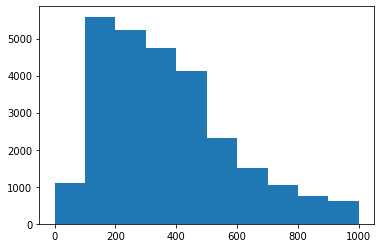

In [41]:
plt.hist(sequence_lengths, range = (0, 1000))

(array([1576.,  277.,   50.,   22.,   17.,    3.,    2.,    3.,    2.,
           0.]),
 array([ 1000.,  1900.,  2800.,  3700.,  4600.,  5500.,  6400.,  7300.,
         8200.,  9100., 10000.]),
 <BarContainer object of 10 artists>)

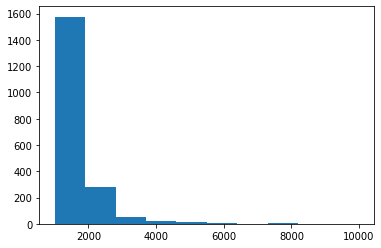

In [42]:
plt.hist(sequence_lengths, range = (1000, 10000))

(array([  3.,   5.,   8.,  13.,  24., 104., 237., 119., 231., 452.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

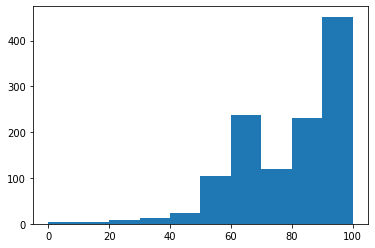

In [43]:
plt.hist(sequence_lengths, range = (0, 100))

In [44]:
len(train_x), len(train_y), len(train_ph)

(22809, 22809, 22809)

In [45]:
train_sequence_lengths = [len(sequence) for sequence in train_x]

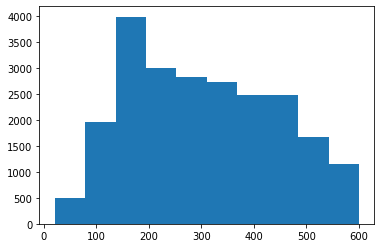

In [46]:
plt.hist(train_sequence_lengths)
plt.show()

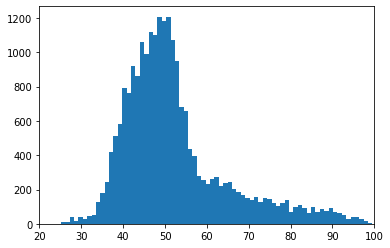

In [47]:
plt.hist(train_y,100)
plt.xlim([20, 100])
plt.show()

In [48]:
counts, bins = np.histogram(train_y, 110, range = (25, 135))

In [49]:
for index, (count_, bin_) in enumerate(zip(counts, bins)):
    print(str(index) + ':' + str(bin_) + ':' + str(count_))

0:25.0:9
1:26.0:10
2:27.0:10
3:28.0:44
4:29.0:18
5:30.0:41
6:31.0:37
7:32.0:49
8:33.0:87
9:34.0:142
10:35.0:194
11:36.0:265
12:37.0:470
13:38.0:468
14:39.0:600
15:40.0:725
16:41.0:795
17:42.0:822
18:43.0:860
19:44.0:922
20:45.0:1015
21:46.0:1045
22:47.0:1065
23:48.0:1105
24:49.0:1128
25:50.0:1162
26:51.0:1066
27:52.0:962
28:53.0:797
29:54.0:600
30:55.0:522
31:56.0:419
32:57.0:356
33:58.0:248
34:59.0:209
35:60.0:246
36:61.0:228
37:62.0:271
38:63.0:205
39:64.0:236
40:65.0:218
41:66.0:213
42:67.0:167
43:68.0:168
44:69.0:139
45:70.0:141
46:71.0:157
47:72.0:131
48:73.0:116
49:74.0:150
50:75.0:128
51:76.0:118
52:77.0:100
53:78.0:115
54:79.0:118
55:80.0:77
56:81.0:89
57:82.0:112
58:83.0:76
59:84.0:69
60:85.0:89
61:86.0:69
62:87.0:77
63:88.0:75
64:89.0:84
65:90.0:72
66:91.0:67
67:92.0:46
68:93.0:33
69:94.0:36
70:95.0:36
71:96.0:33
72:97.0:19
73:98.0:10
74:99.0:1
75:100.0:0
76:101.0:0
77:102.0:0
78:103.0:2
79:104.0:0
80:105.0:0
81:106.0:0
82:107.0:0
83:108.0:1
84:109.0:1
85:110.0:0
86:111.0:1
8

In [50]:
maxCount = max(counts)
print(maxCount)

1162


In [51]:
train_repsToStratify = [] 
reps = 0
for x, y, pH in zip(train_x, train_y, train_ph):
    #if y < 20 or y >= 100:
    #    continue
    bin_index = int(1 * (y - 25))
    bin_count = counts[bin_index]
    if bin_count == 0:
        train_repsToStratify.append(0)
    else:
        repToStratify = int((maxCount // bin_count) * 0.8) + 1
        print('y: ' + str(y) + ' counts: ' + str(bin_count) + ' reps to stratify: ' + str(repToStratify))
        train_repsToStratify.append(repToStratify)

y: 75.7 counts: 128 reps to stratify: 8
y: 50.5 counts: 1162 reps to stratify: 1
y: 40.5 counts: 725 reps to stratify: 1
y: 47.2 counts: 1065 reps to stratify: 1
y: 48.4 counts: 1105 reps to stratify: 1
y: 45.7 counts: 1015 reps to stratify: 1
y: 55.9 counts: 522 reps to stratify: 2
y: 48.1 counts: 1105 reps to stratify: 1
y: 49.7 counts: 1128 reps to stratify: 1
y: 45.1 counts: 1015 reps to stratify: 1
y: 60.6 counts: 246 reps to stratify: 4
y: 62.8 counts: 271 reps to stratify: 4
y: 36.3 counts: 265 reps to stratify: 4
y: 44.7 counts: 922 reps to stratify: 1
y: 83.0 counts: 76 reps to stratify: 13
y: 43.3 counts: 860 reps to stratify: 1
y: 44.3 counts: 922 reps to stratify: 1
y: 42.5 counts: 822 reps to stratify: 1
y: 37.9 counts: 470 reps to stratify: 2
y: 65.1 counts: 218 reps to stratify: 5
y: 44.5 counts: 922 reps to stratify: 1
y: 50.6 counts: 1162 reps to stratify: 1
y: 65.4 counts: 218 reps to stratify: 5
y: 37.9 counts: 470 reps to stratify: 2
y: 45.2 counts: 1015 reps to str

In [52]:
len(train_repsToStratify)

22809

## Changing the sequence to embedding vector

First define a function..
averaging hidden states of the last layer... we may be losing some important information

In [53]:
def ESMembedding(input_sequence):
    input_data = [("protein1", input_sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(input_data)
    batch_labels, batch_strs, batch_tokens = batch_labels, batch_strs, batch_tokens.cuda()
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    token_representations = results["representations"][33]
    sequence_representations = token_representations[0, 1 : len(input_sequence) + 1].mean(0)
    return sequence_representations.cpu().numpy()

In [54]:
model = model.cuda()

In [55]:
test_embedding = ESMembedding(train_x[0])

In [56]:
test_embedding

array([ 0.07047152, -0.10383302, -0.00030396, ..., -0.08737316,
       -0.00137351,  0.04592499], dtype=float32)

In [57]:
len(test_embedding)

1280

In [58]:
ph_ = np.array(train_ph[0])

In [59]:
ph_

array(7.)

In [60]:
test_embedding = np.hstack([test_embedding, ph_])

In [61]:
test_embedding

array([ 7.04715177e-02, -1.03833020e-01, -3.03955720e-04, ...,
       -1.37351162e-03,  4.59249876e-02,  7.00000000e+00])

In [62]:
torch.cuda.empty_cache()

In [63]:
# Uncomment the lines in the below if you dont have save embeddings

In [64]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 1906),
             ('active.all.current', 637),
             ('active.all.freed', 1269),
             ('active.all.peak', 684),
             ('active.large_pool.allocated', 1108),
             ('active.large_pool.current', 199),
             ('active.large_pool.freed', 909),
             ('active.large_pool.peak', 240),
             ('active.small_pool.allocated', 798),
             ('active.small_pool.current', 438),
             ('active.small_pool.freed', 360),
             ('active.small_pool.peak', 446),
             ('active_bytes.all.allocated', 7610672640),
             ('active_bytes.all.current', 2679209472),
             ('active_bytes.all.freed', 4931463168),
             ('active_bytes.all.peak', 4536413696),
             ('active_bytes.large_pool.allocated', 7536453120),
             ('active_bytes.large_pool.current', 2670985216),
             ('active_bytes.large_pool.freed', 4865467904),
             ('active_bytes.large_pool.peak

In [65]:
torch.cuda.memory_summary()

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    2555 MB |    4326 MB |    7258 MB |    4703 MB |\n|       from large pool |    2547 MB |    4316 MB |    7187 MB |    4640 MB |\n|       from small pool |       7 MB |      10 MB |      70 MB |      62 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |    2555 MB |    4326 MB |    7258 MB |    4703 MB |\n|       from large pool |    2547 MB |    4316 MB |

In [66]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:4096'

In [67]:
train_x_embed_stratified = []
train_y_stratified = []
train_ph_stratified = []

for i, (sequence, y, pH) in enumerate(zip(train_x, train_y, train_ph)):
    if i % 100 == 0:
        print("Working on sequence {}...".format(i))
    embed = ESMembedding(sequence)
    for reps in range(train_repsToStratify[i]):
        train_x_embed_stratified.append(embed)
        train_y_stratified.append(y)
        train_ph_stratified.append(pH)

Working on sequence 0...
Working on sequence 100...
Working on sequence 200...
Working on sequence 300...
Working on sequence 400...
Working on sequence 500...
Working on sequence 600...
Working on sequence 700...
Working on sequence 800...
Working on sequence 900...
Working on sequence 1000...
Working on sequence 1100...
Working on sequence 1200...
Working on sequence 1300...
Working on sequence 1400...
Working on sequence 1500...
Working on sequence 1600...
Working on sequence 1700...
Working on sequence 1800...
Working on sequence 1900...
Working on sequence 2000...
Working on sequence 2100...
Working on sequence 2200...
Working on sequence 2300...
Working on sequence 2400...
Working on sequence 2500...
Working on sequence 2600...
Working on sequence 2700...
Working on sequence 2800...
Working on sequence 2900...
Working on sequence 3000...
Working on sequence 3100...
Working on sequence 3200...
Working on sequence 3300...
Working on sequence 3400...
Working on sequence 3500...
Work

### trying to save these

In [68]:
import pickle

with open("train_x_embed_stratified_latest.pl", "wb") as fp:   #Pickling
    pickle.dump(train_x_embed_stratified, fp)

In [ ]:
import pickle
with open("train_x_embed_stratified_latest.pl", "rb") as fp:
    # Unpickling
    train_x_embed_stratified = pickle.load(fp)

In [69]:
len(train_x_embed_stratified)

77231

In [70]:
train_x_embed_stratified[0].shape

(1280,)

In [71]:
len(train_x_embed_stratified)

77231

In [72]:
train_x_embed_stratified_new = [x.reshape([1, -1]) for x in train_x_embed_stratified]

In [73]:
train_x_embed_stratified_new2 = np.vstack(train_x_embed_stratified_new)

In [74]:
train_x_embed_stratified_new2.shape

(77231, 1280)

In [ ]:
#This is not needed anymore after dataset fix

import math

average_pH = np.nanmean(np.array(train_ph_stratified))
print(average_pH)

count = 0

for index, p in enumerate(train_ph_stratified):
    if math.isnan(p):
        train_ph_stratified[index] = average_pH

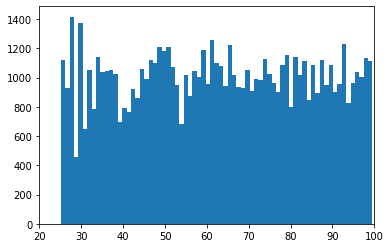

In [75]:
plt.hist(train_y_stratified,100)
plt.xlim([25, 125])
plt.show()

In [76]:
print(len(train_x))
print(len(train_y))
print(len(train_ph))

22809
22809
22809


In [77]:
train_x.clear()
train_y.clear()
train_ph.clear()

In [78]:
print(len(train_x_embed_stratified))
print(len(train_y_stratified))
print(len(train_ph_stratified))

77231
77231
77231


In [79]:
train_ph_stratified_list = np.array(train_ph_stratified).reshape([-1, 1])

In [80]:
print(len(train_ph_stratified))
train_ph_stratified.clear()
print(len(train_ph_stratified))

77231
0


In [81]:
train_ph_stratified_list.shape

(77231, 1)

In [82]:
train_ph_stratified_list = train_ph_stratified_list / 14

In [83]:
train_x_embed_stratified_with_ph = np.hstack([train_x_embed_stratified_new2, train_ph_stratified_list])

In [84]:
train_x_embed_stratified_with_ph.shape

(77231, 1281)

In [85]:
train_x_embed_stratified_with_ph[112]

array([ 0.08855153, -0.12198227, -0.06630865, ...,  0.0595332 ,
       -0.11209799,  0.5       ])

In [86]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_x_embed_stratified_with_ph, train_y_stratified, test_size=0.1, random_state=42, shuffle = True)

In [87]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('train_x_embed_stratified_with_ph', 791463416),
 ('X_train', 712307864),
 ('train_x_embed_stratified_new2', 395422848),
 ('X_test', 79155680),
 ('data', 18971748),
 ('df_train', 18971748),
 ('train_x_embed_stratified', 651344),
 ('train_x_embed_stratified_new', 651344),
 ('train_y_stratified', 651344),
 ('train_ph_stratified_list', 617976),
 ('y_train', 578928),
 ('sequence_lengths', 253624),
 ('ph', 231904),
 ('df_train_updates', 225013),
 ('train_repsToStratify', 200312),
 ('train_sequence_lengths', 200312),
 ('all_features_nan', 88010),
 ('y_test', 69152),
 ('drop_indices', 19288),
 ('test_embedding', 10360),
 ('counts', 992),
 ('sequence', 586),
 ('x', 586),
 ('seq', 335),
 ('logits', 232),
 ('newresults', 232),
 ('results', 232),
 ('swap_ph_tm_indices', 216),
 ('fp', 168),
 ('ESMembedding', 136),
 ('train_test_split', 136),
 ('sequence_representations', 120),
 ('bins', 112),
 ('embed', 112),
 ('ph_', 104),
 ('batch_labels', 88),
 ('batch_strs', 88),
 ('attention_contacts', 72),


In [88]:
del train_x_embed_stratified_with_ph
del train_x_embed_stratified_new2
del data
del df_train
del train_x_embed_stratified
del train_x_embed_stratified_new

## Things to try first:
- GBM
- Random forrest
- kNN regression

In [89]:
X_train.shape

(69507, 1281)

In [90]:
X_train[0]

array([ 0.05173805, -0.06133159, -0.01312   , ...,  0.01988917,
        0.00614086,  0.5       ])

In [92]:
from sklearn.neighbors import KNeighborsRegressor
kNN = KNeighborsRegressor(n_neighbors = 10, weights = 'uniform')
kNN.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [93]:
y_test_hat = kNN.predict(X_test)

In [94]:
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, y_test_hat)

print(MSE ** 0.5)

5.913490406317011


In [95]:
print(y_test_hat[:20])

[56.5  60.32 64.36 98.3  58.37 69.3  96.5  99.   52.58 81.26 28.5  34.87
 48.32 44.14 87.   33.55 36.5  27.9  72.5  60.48]


In [96]:
print(y_test[:20])

[55.9, 66.5, 65.0, 98.3, 58.9, 69.6, 96.5, 99.0, 49.6, 81.6, 29.6, 44.5, 47.7, 49.2, 87.0, 33.7, 58.9, 27.9, 65.5, 65.5]


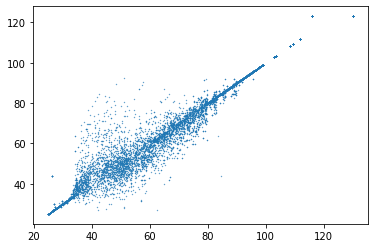

In [97]:
import matplotlib.pyplot as plt


plt.scatter(y_test, y_test_hat, s = .1)
plt.show()

In [98]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

corr, _ = pearsonr(y_test, y_test_hat)
print('Pearsons correlation: %.3f' % corr)

r2_score_ = r2_score(y_test, y_test_hat)
print('r2 score: %.3f' % r2_score_)

Pearsons correlation: 0.970
r2 score: 0.941


# Pytorch

In [99]:
import torch
from torch import nn
from torch import optim

#input_dim = 1281
input_dim = 1281 * 2

hidden_dim = 650
hidden_dim2 = 200
hidden_dim3 = 50

output_dim = 1

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        nn.init.xavier_uniform_(self.fc1.weight)
        #self.norm1 = nn.BatchNorm1d(hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim2)
        nn.init.xavier_uniform_(self.fc2.weight)
        #self.norm2 = nn.BatchNorm1d(hidden_dim2)
        
        #self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim2, output_dim)
        nn.init.xavier_uniform_(self.fc4.weight)
       
    def forward(self, x):
        #x = torch.nn.functional.relu(self.norm1(self.fc1(x)))
        x = torch.nn.functional.relu(self.fc1(x))
        
        x = torch.nn.functional.relu(self.fc2(x))
        
        #x = self.fc3(x)
        x = self.fc4(x)

        return x
       
modelnn = Net(input_dim, hidden_dim, output_dim)
print(modelnn)

Net(
  (fc1): Linear(in_features=2562, out_features=650, bias=True)
  (fc2): Linear(in_features=650, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)


In [671]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Available device: " + device)
device = torch.device(device)
modelnn = modelnn.to(device)
learning_rate = 0.0005
loss_fn = nn.HuberLoss(reduction='sum', delta=0.1)
#loss_fn = nn.MarginRankingLoss()

optimizer = torch.optim.Adam(modelnn.parameters(), lr=learning_rate)

loss_fn = loss_fn.to(device)
print(device)

Available device: cuda:0
cuda:0


In [101]:
import random

In [103]:
%autosave 0

Autosave disabled


In [104]:
#modelnn.load_state_dict(torch.load('DualLoopModel_AlwaysRandomize'))

In [106]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [107]:
class DataFromTorch(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [108]:
X_train.shape

(69507, 1281)

In [109]:
len(y_train)

69507

In [110]:
y_train_np = np.array(y_train)

In [111]:
y_train_np_normalized = y_train_np / 100

In [112]:
y_train_np_normalized.shape

(69507,)

In [113]:
X_train_torch = torch.from_numpy(X_train.astype(np.float32)).to(device)

In [114]:
y_train_torch = torch.from_numpy(y_train_np_normalized.astype(np.float32)).to(device)

In [115]:
class DataFromTorch(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = self.X.shape[0]
       
    def __getitem__(self, index):
        return self.X[index], self.y[index]
   
    def __len__(self):
        return self.len

In [117]:
batch_size = 512

In [118]:
train_data = DataFromTorch(X_train_torch, y_train_torch)
train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

In [119]:
X_train_torch.shape

torch.Size([69507, 1281])

In [120]:
y_train_torch.shape

torch.Size([69507])

In [121]:
y_train_torch[:10]

tensor([0.7730, 0.8320, 1.0950, 0.6200, 0.8070, 0.6120, 0.3670, 0.4670, 0.9390,
        0.7660], device='cuda:0')

In [123]:
device

device(type='cuda', index=0)

In [124]:
modelnn.to(device)

Net(
  (fc1): Linear(in_features=2562, out_features=650, bias=True)
  (fc2): Linear(in_features=650, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)

In [692]:
print('starting the cell')
num_outer_epochs = 5000
num_epochs = 10
#loss_values = []
modelnn.train()


#SamplesPerTraining = 4
NumberTraings = X_train.shape[0]

print('Starting the outer loop...')
for outer_epoch in range(num_outer_epochs):
    
    Epoch_loss = 0
    
    for index, (X1, y1) in enumerate(train_dataloader):
        #print(X1.shape)
        #print(y1.shape)
        
        random_list = torch.randperm(X_train_torch.shape[0])[:X1.shape[0]]
        #print(random_list.shape)
        #print(random_list)
        X2 = X_train_torch[random_list]
        #print('X2 works and its shape is ' + str(X2.shape))
            
        X = torch.cat((X1, X2), 1)
        #print('X works and its shape is ' + str(X.shape))
            
        y2 = y_train_torch[random_list]
        #print('y2 works and its shape is ' + str(y2.shape))
        
        Batch_loss = 0
        
        for epoch in range(num_epochs):
            
            optimizer.zero_grad()
            pred = modelnn(X)
            y    = (y1-y2).unsqueeze(-1)
            loss = loss_fn(pred, y)
            Batch_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            
        
        Epoch_loss += Batch_loss
        #print('Batch: ' + str(index) + '\t Loss: ' + str(Batch_loss))
            
    print('Epoch: ' + str(outer_epoch) + '\t Loss: ' + str(Epoch_loss))   

starting the cell
Starting the outer loop...
Epoch: 0	 Loss: 545.2300456911325
Epoch: 1	 Loss: 551.8882289975882
Epoch: 2	 Loss: 551.1832168251276
Epoch: 3	 Loss: 549.3592537045479
Epoch: 4	 Loss: 545.2152778208256
Epoch: 5	 Loss: 567.4516972750425
Epoch: 6	 Loss: 552.6039894521236
Epoch: 7	 Loss: 555.7396753132343
Epoch: 8	 Loss: 563.7659902870655
Epoch: 9	 Loss: 546.6221034824848
Epoch: 10	 Loss: 534.8032259941101
Epoch: 11	 Loss: 538.0893716961145
Epoch: 12	 Loss: 550.5401953607798
Epoch: 13	 Loss: 539.8178940415382
Epoch: 14	 Loss: 525.5646105855703
Epoch: 15	 Loss: 534.9594018608332
Epoch: 16	 Loss: 555.8030886948109
Epoch: 17	 Loss: 534.5614663660526
Epoch: 18	 Loss: 535.5484159737825
Epoch: 19	 Loss: 528.8283421397209
Epoch: 20	 Loss: 530.5523951351643
Epoch: 21	 Loss: 528.8061131834984
Epoch: 22	 Loss: 524.1209809333086
Epoch: 23	 Loss: 526.4763548448682
Epoch: 24	 Loss: 525.0548718869686
Epoch: 25	 Loss: 535.2017803937197
Epoch: 26	 Loss: 527.1953871548176
Epoch: 27	 Loss: 525

Epoch: 228	 Loss: 412.3912795484066
Epoch: 229	 Loss: 413.02879372239113
Epoch: 230	 Loss: 420.15131720900536
Epoch: 231	 Loss: 412.24706158041954
Epoch: 232	 Loss: 402.2712948471308
Epoch: 233	 Loss: 406.2445419281721
Epoch: 234	 Loss: 411.5535169839859
Epoch: 235	 Loss: 399.3170502334833
Epoch: 236	 Loss: 403.65954054892063
Epoch: 237	 Loss: 421.4099505543709
Epoch: 238	 Loss: 410.01393288373947
Epoch: 239	 Loss: 411.849474132061
Epoch: 240	 Loss: 402.6693225428462
Epoch: 241	 Loss: 403.99996370077133
Epoch: 242	 Loss: 413.33976785838604
Epoch: 243	 Loss: 410.83485163748264
Epoch: 244	 Loss: 413.0350771397352
Epoch: 245	 Loss: 409.32733534276485
Epoch: 246	 Loss: 414.0636816620827
Epoch: 247	 Loss: 400.88092278689146
Epoch: 248	 Loss: 409.7707008719444
Epoch: 249	 Loss: 406.52003814280033
Epoch: 250	 Loss: 403.3024851381779
Epoch: 251	 Loss: 403.87874218821526
Epoch: 252	 Loss: 399.6503147482872
Epoch: 253	 Loss: 412.42673337459564
Epoch: 254	 Loss: 407.49501752853394
Epoch: 255	 Los

Epoch: 454	 Loss: 367.18932355195284
Epoch: 455	 Loss: 371.3375672325492
Epoch: 456	 Loss: 367.7895301505923
Epoch: 457	 Loss: 368.05668483674526
Epoch: 458	 Loss: 368.09739646315575
Epoch: 459	 Loss: 368.6146197319031
Epoch: 460	 Loss: 368.7208486646414
Epoch: 461	 Loss: 371.8233439028263
Epoch: 462	 Loss: 358.4264708980918
Epoch: 463	 Loss: 376.0076256990433
Epoch: 464	 Loss: 369.9228938296437
Epoch: 465	 Loss: 362.69543550908566
Epoch: 466	 Loss: 364.07825116068125
Epoch: 467	 Loss: 358.7381660491228
Epoch: 468	 Loss: 360.75612253695726
Epoch: 469	 Loss: 366.9022214785218
Epoch: 470	 Loss: 358.73063108325005
Epoch: 471	 Loss: 368.4832363128662
Epoch: 472	 Loss: 363.73727701604366
Epoch: 473	 Loss: 376.91165731847286
Epoch: 474	 Loss: 357.4993474856019
Epoch: 475	 Loss: 368.2918436899781
Epoch: 476	 Loss: 367.4682887196541
Epoch: 477	 Loss: 369.01811826229095
Epoch: 478	 Loss: 367.89317870885134
Epoch: 479	 Loss: 363.8612780496478
Epoch: 480	 Loss: 365.9811533689499
Epoch: 481	 Loss:

Epoch: 680	 Loss: 345.68497631698847
Epoch: 681	 Loss: 337.24351351708174
Epoch: 682	 Loss: 339.9919437542558
Epoch: 683	 Loss: 347.8461684733629
Epoch: 684	 Loss: 348.18526408821344
Epoch: 685	 Loss: 352.1875517144799
Epoch: 686	 Loss: 338.5889173820615
Epoch: 687	 Loss: 350.188769236207
Epoch: 688	 Loss: 341.6162643879652
Epoch: 689	 Loss: 345.90692661702633
Epoch: 690	 Loss: 344.87161788344383
Epoch: 691	 Loss: 342.17543456703424
Epoch: 692	 Loss: 340.16207878291607
Epoch: 693	 Loss: 345.01698738336563
Epoch: 694	 Loss: 343.3301490843296
Epoch: 695	 Loss: 340.9080066755414
Epoch: 696	 Loss: 343.7620146423578
Epoch: 697	 Loss: 341.4445141404867
Epoch: 698	 Loss: 339.7788605839014
Epoch: 699	 Loss: 345.43142918497324
Epoch: 700	 Loss: 336.0611356496811
Epoch: 701	 Loss: 343.9908966422081
Epoch: 702	 Loss: 337.2314812093973
Epoch: 703	 Loss: 339.9514196962118
Epoch: 704	 Loss: 338.47261026501656
Epoch: 705	 Loss: 336.0106078237295
Epoch: 706	 Loss: 337.3955525010824
Epoch: 707	 Loss: 3

Epoch: 906	 Loss: 324.2189916521311
Epoch: 907	 Loss: 336.1032641530037
Epoch: 908	 Loss: 325.4127071723342
Epoch: 909	 Loss: 326.49987749010324
Epoch: 910	 Loss: 324.32400012016296
Epoch: 911	 Loss: 337.351480640471
Epoch: 912	 Loss: 329.06909696757793
Epoch: 913	 Loss: 327.99617762863636
Epoch: 914	 Loss: 325.8319779038429
Epoch: 915	 Loss: 335.07565192878246
Epoch: 916	 Loss: 334.4934652596712
Epoch: 917	 Loss: 332.11640468239784
Epoch: 918	 Loss: 331.7085328027606
Epoch: 919	 Loss: 329.07858619093895
Epoch: 920	 Loss: 333.728185556829
Epoch: 921	 Loss: 324.06966622918844
Epoch: 922	 Loss: 324.7329266965389
Epoch: 923	 Loss: 335.4234418347478
Epoch: 924	 Loss: 329.69675179570913
Epoch: 925	 Loss: 323.3183479234576
Epoch: 926	 Loss: 333.2497448772192
Epoch: 927	 Loss: 322.26016215234995
Epoch: 928	 Loss: 328.8666242957115
Epoch: 929	 Loss: 327.2113800123334
Epoch: 930	 Loss: 322.9584149196744
Epoch: 931	 Loss: 323.7218772098422
Epoch: 932	 Loss: 331.31874519586563
Epoch: 933	 Loss: 3

Epoch: 1128	 Loss: 316.958160020411
Epoch: 1129	 Loss: 324.293595507741
Epoch: 1130	 Loss: 331.9236056804657
Epoch: 1131	 Loss: 315.1374967843294
Epoch: 1132	 Loss: 322.8455935791135
Epoch: 1133	 Loss: 323.42916409671307
Epoch: 1134	 Loss: 312.0046902894974
Epoch: 1135	 Loss: 314.273073323071
Epoch: 1136	 Loss: 313.3804706707597
Epoch: 1137	 Loss: 319.29595352709293
Epoch: 1138	 Loss: 313.70064628124237
Epoch: 1139	 Loss: 323.6456599384546
Epoch: 1140	 Loss: 313.2783579751849
Epoch: 1141	 Loss: 314.7036296874285
Epoch: 1142	 Loss: 317.22922023013234
Epoch: 1143	 Loss: 315.84712954610586
Epoch: 1144	 Loss: 315.4636427015066
Epoch: 1145	 Loss: 318.36331617832184
Epoch: 1146	 Loss: 315.68057046830654
Epoch: 1147	 Loss: 316.5456699952483
Epoch: 1148	 Loss: 314.3649077564478
Epoch: 1149	 Loss: 320.8750001862645
Epoch: 1150	 Loss: 317.8179153650999
Epoch: 1151	 Loss: 316.71630722284317
Epoch: 1152	 Loss: 323.1119230762124
Epoch: 1153	 Loss: 320.5972960740328
Epoch: 1154	 Loss: 319.1443733721

Epoch: 1348	 Loss: 317.9689046666026
Epoch: 1349	 Loss: 307.170103110373
Epoch: 1350	 Loss: 307.66841155290604
Epoch: 1351	 Loss: 312.35064040869474
Epoch: 1352	 Loss: 310.0610961690545
Epoch: 1353	 Loss: 309.00859098881483
Epoch: 1354	 Loss: 298.3631528392434
Epoch: 1355	 Loss: 298.9918393269181
Epoch: 1356	 Loss: 309.3290754854679
Epoch: 1357	 Loss: 315.54621267318726
Epoch: 1358	 Loss: 309.80377539247274
Epoch: 1359	 Loss: 311.80797439068556
Epoch: 1360	 Loss: 310.5949274674058
Epoch: 1361	 Loss: 313.7908217534423
Epoch: 1362	 Loss: 308.2937796264887
Epoch: 1363	 Loss: 306.5642926990986
Epoch: 1364	 Loss: 310.85192508250475
Epoch: 1365	 Loss: 314.55217333883047
Epoch: 1366	 Loss: 313.13050851225853
Epoch: 1367	 Loss: 304.57956521213055
Epoch: 1368	 Loss: 304.22293297946453
Epoch: 1369	 Loss: 326.2175628915429
Epoch: 1370	 Loss: 303.8449975848198
Epoch: 1371	 Loss: 313.27563855051994
Epoch: 1372	 Loss: 303.83202194422483
Epoch: 1373	 Loss: 306.21344900131226
Epoch: 1374	 Loss: 316.57

Epoch: 1568	 Loss: 298.5785951241851
Epoch: 1569	 Loss: 293.0677191466093
Epoch: 1570	 Loss: 302.26659143716097
Epoch: 1571	 Loss: 300.4748320505023
Epoch: 1572	 Loss: 297.30116138607264
Epoch: 1573	 Loss: 305.2555870041251
Epoch: 1574	 Loss: 307.8202586695552
Epoch: 1575	 Loss: 300.8117512613535
Epoch: 1576	 Loss: 301.3367307782173
Epoch: 1577	 Loss: 307.43854780495167
Epoch: 1578	 Loss: 309.51400914788246
Epoch: 1579	 Loss: 302.93931671977043
Epoch: 1580	 Loss: 297.40060248970985
Epoch: 1581	 Loss: 301.7199746221304
Epoch: 1582	 Loss: 303.6712763682008
Epoch: 1583	 Loss: 300.69747737795115
Epoch: 1584	 Loss: 305.6011368408799
Epoch: 1585	 Loss: 309.0623128414154
Epoch: 1586	 Loss: 299.44314432889223
Epoch: 1587	 Loss: 301.13862132281065
Epoch: 1588	 Loss: 300.1226834580302
Epoch: 1589	 Loss: 302.4570822715759
Epoch: 1590	 Loss: 304.0588474199176
Epoch: 1591	 Loss: 300.3395962640643
Epoch: 1592	 Loss: 301.31056170910597
Epoch: 1593	 Loss: 300.37627044320107
Epoch: 1594	 Loss: 314.3956

Epoch: 1788	 Loss: 298.9274251013994
Epoch: 1789	 Loss: 297.0969405248761
Epoch: 1790	 Loss: 304.861760571599
Epoch: 1791	 Loss: 293.8612040579319
Epoch: 1792	 Loss: 307.449479483068
Epoch: 1793	 Loss: 301.91450311243534
Epoch: 1794	 Loss: 302.25156965851784
Epoch: 1795	 Loss: 305.2433664947748
Epoch: 1796	 Loss: 300.2395683825016
Epoch: 1797	 Loss: 291.65160991996527
Epoch: 1798	 Loss: 297.1085910499096
Epoch: 1799	 Loss: 297.93997260928154
Epoch: 1800	 Loss: 295.70008462667465
Epoch: 1801	 Loss: 303.6177926212549
Epoch: 1802	 Loss: 302.7412625178695
Epoch: 1803	 Loss: 303.42760802805424
Epoch: 1804	 Loss: 301.69460559636354
Epoch: 1805	 Loss: 303.32357908040285
Epoch: 1806	 Loss: 299.401537746191
Epoch: 1807	 Loss: 294.61504792422056
Epoch: 1808	 Loss: 300.37497115135193
Epoch: 1809	 Loss: 302.8595961108804
Epoch: 1810	 Loss: 294.7602733820677
Epoch: 1811	 Loss: 307.47816924750805
Epoch: 1812	 Loss: 302.7847229465842
Epoch: 1813	 Loss: 298.9493582844734
Epoch: 1814	 Loss: 297.7426525

Epoch: 2008	 Loss: 292.65118899941444
Epoch: 2009	 Loss: 292.8684122040868
Epoch: 2010	 Loss: 291.4235125333071
Epoch: 2011	 Loss: 286.0241399332881
Epoch: 2012	 Loss: 291.73092169314623
Epoch: 2013	 Loss: 293.08662401139736
Epoch: 2014	 Loss: 289.75390906631947
Epoch: 2015	 Loss: 289.8281124457717
Epoch: 2016	 Loss: 291.23723889887333
Epoch: 2017	 Loss: 282.7273035272956
Epoch: 2018	 Loss: 288.43385694921017
Epoch: 2019	 Loss: 298.2397603094578
Epoch: 2020	 Loss: 286.94214252382517
Epoch: 2021	 Loss: 289.56891556829214
Epoch: 2022	 Loss: 289.93747920542955
Epoch: 2023	 Loss: 291.2348641753197
Epoch: 2024	 Loss: 294.2885740175843
Epoch: 2025	 Loss: 286.3431563153863
Epoch: 2026	 Loss: 292.9390842616558
Epoch: 2027	 Loss: 288.8455248773098
Epoch: 2028	 Loss: 284.9999511614442
Epoch: 2029	 Loss: 294.61153127998114
Epoch: 2030	 Loss: 295.66608261317015
Epoch: 2031	 Loss: 292.21256896853447
Epoch: 2032	 Loss: 295.0597524866462
Epoch: 2033	 Loss: 290.3964169025421
Epoch: 2034	 Loss: 289.251

Epoch: 2228	 Loss: 288.7229949980974
Epoch: 2229	 Loss: 297.5222622975707
Epoch: 2230	 Loss: 294.10854583978653
Epoch: 2231	 Loss: 287.2388445287943
Epoch: 2232	 Loss: 291.02110289782286
Epoch: 2233	 Loss: 282.7191435918212
Epoch: 2234	 Loss: 292.8343012034893
Epoch: 2235	 Loss: 286.34430016577244
Epoch: 2236	 Loss: 292.7455846518278
Epoch: 2237	 Loss: 291.0321728512645
Epoch: 2238	 Loss: 288.05649661272764
Epoch: 2239	 Loss: 288.1684741973877
Epoch: 2240	 Loss: 284.0511881187558
Epoch: 2241	 Loss: 280.2482272684574
Epoch: 2242	 Loss: 286.7296669110656
Epoch: 2243	 Loss: 289.8898395523429
Epoch: 2244	 Loss: 278.31594613194466
Epoch: 2245	 Loss: 279.6250220760703
Epoch: 2246	 Loss: 285.90470097213984
Epoch: 2247	 Loss: 282.4207512438297
Epoch: 2248	 Loss: 286.93255066871643
Epoch: 2249	 Loss: 287.6372334957123
Epoch: 2250	 Loss: 286.77539177984
Epoch: 2251	 Loss: 284.9602428302169
Epoch: 2252	 Loss: 284.9150401055813
Epoch: 2253	 Loss: 287.7183254137635
Epoch: 2254	 Loss: 293.4709488898

Epoch: 2448	 Loss: 284.58268258720636
Epoch: 2449	 Loss: 292.13914129137993
Epoch: 2450	 Loss: 277.6392795294523
Epoch: 2451	 Loss: 278.03351882100105
Epoch: 2452	 Loss: 285.47506769001484
Epoch: 2453	 Loss: 294.32910703122616
Epoch: 2454	 Loss: 277.7042060121894
Epoch: 2455	 Loss: 279.49791488051414
Epoch: 2456	 Loss: 284.0096990764141
Epoch: 2457	 Loss: 291.27921395748854
Epoch: 2458	 Loss: 287.6665721833706
Epoch: 2459	 Loss: 282.0074884071946
Epoch: 2460	 Loss: 287.0017088353634
Epoch: 2461	 Loss: 291.90461254119873
Epoch: 2462	 Loss: 285.8835065513849
Epoch: 2463	 Loss: 282.1512616202235
Epoch: 2464	 Loss: 276.53809571266174
Epoch: 2465	 Loss: 290.51820815354586
Epoch: 2466	 Loss: 285.4903101399541
Epoch: 2467	 Loss: 284.3953454941511
Epoch: 2468	 Loss: 276.2760593369603
Epoch: 2469	 Loss: 284.9517671316862
Epoch: 2470	 Loss: 281.7130903750658
Epoch: 2471	 Loss: 282.6120637357235
Epoch: 2472	 Loss: 283.0770818144083
Epoch: 2473	 Loss: 285.3267148286104
Epoch: 2474	 Loss: 284.52342

Epoch: 2668	 Loss: 284.119042403996
Epoch: 2669	 Loss: 284.0597617328167
Epoch: 2670	 Loss: 286.9898177906871
Epoch: 2671	 Loss: 283.9927311614156
Epoch: 2672	 Loss: 277.8351397290826
Epoch: 2673	 Loss: 281.39758652448654
Epoch: 2674	 Loss: 278.3325816169381
Epoch: 2675	 Loss: 280.351972296834
Epoch: 2676	 Loss: 287.9605452567339
Epoch: 2677	 Loss: 283.78661166131496
Epoch: 2678	 Loss: 285.0302547439933
Epoch: 2679	 Loss: 276.6393331810832
Epoch: 2680	 Loss: 284.27899188548326
Epoch: 2681	 Loss: 286.85247875005007
Epoch: 2682	 Loss: 275.26953099668026
Epoch: 2683	 Loss: 282.2186126932502
Epoch: 2684	 Loss: 282.81177542358637
Epoch: 2685	 Loss: 287.30968856811523
Epoch: 2686	 Loss: 279.8099791035056
Epoch: 2687	 Loss: 277.9634231477976
Epoch: 2688	 Loss: 281.8428703546524
Epoch: 2689	 Loss: 283.96280112862587
Epoch: 2690	 Loss: 276.1135870963335
Epoch: 2691	 Loss: 285.86500453203917
Epoch: 2692	 Loss: 286.75718899071217
Epoch: 2693	 Loss: 282.0720504745841
Epoch: 2694	 Loss: 283.3164541

Epoch: 2888	 Loss: 272.56607610732317
Epoch: 2889	 Loss: 274.63393150269985
Epoch: 2890	 Loss: 273.2006915360689
Epoch: 2891	 Loss: 272.4035479128361
Epoch: 2892	 Loss: 274.4840159416199
Epoch: 2893	 Loss: 283.86421167850494
Epoch: 2894	 Loss: 280.82675725221634
Epoch: 2895	 Loss: 285.16199899464846
Epoch: 2896	 Loss: 281.18964825570583
Epoch: 2897	 Loss: 274.7181443050504
Epoch: 2898	 Loss: 282.64354552328587
Epoch: 2899	 Loss: 276.56403210759163
Epoch: 2900	 Loss: 278.34827146679163
Epoch: 2901	 Loss: 274.78810600191355
Epoch: 2902	 Loss: 281.14527156203985
Epoch: 2903	 Loss: 273.6167843192816
Epoch: 2904	 Loss: 275.49632174521685
Epoch: 2905	 Loss: 282.0304982662201
Epoch: 2906	 Loss: 278.5456866696477
Epoch: 2907	 Loss: 285.23443711549044
Epoch: 2908	 Loss: 267.5945695564151
Epoch: 2909	 Loss: 283.50494319945574
Epoch: 2910	 Loss: 278.13587814569473
Epoch: 2911	 Loss: 278.23065032064915
Epoch: 2912	 Loss: 273.3965186998248
Epoch: 2913	 Loss: 280.53331073373556
Epoch: 2914	 Loss: 27

Epoch: 3107	 Loss: 272.16663920879364
Epoch: 3108	 Loss: 267.2385600656271
Epoch: 3109	 Loss: 281.7169570699334
Epoch: 3110	 Loss: 282.84654305130243
Epoch: 3111	 Loss: 272.0100203603506
Epoch: 3112	 Loss: 273.21834721416235
Epoch: 3113	 Loss: 267.52373734116554
Epoch: 3114	 Loss: 275.0192626863718
Epoch: 3115	 Loss: 273.969052515924
Epoch: 3116	 Loss: 274.646987169981
Epoch: 3117	 Loss: 279.70953699201345
Epoch: 3118	 Loss: 276.4948129057884
Epoch: 3119	 Loss: 290.4447760209441
Epoch: 3120	 Loss: 272.934544056654
Epoch: 3121	 Loss: 281.7325982823968
Epoch: 3122	 Loss: 279.5136743783951
Epoch: 3123	 Loss: 273.5656813904643
Epoch: 3124	 Loss: 273.0753430724144
Epoch: 3125	 Loss: 281.7458468005061
Epoch: 3126	 Loss: 268.5944829881191
Epoch: 3127	 Loss: 279.3363321349025
Epoch: 3128	 Loss: 276.54696341603994
Epoch: 3129	 Loss: 282.54956905543804
Epoch: 3130	 Loss: 272.01233265548944
Epoch: 3131	 Loss: 271.78927255421877
Epoch: 3132	 Loss: 270.926877386868
Epoch: 3133	 Loss: 277.2254332602

Epoch: 3327	 Loss: 275.33747747540474
Epoch: 3328	 Loss: 279.9997396990657
Epoch: 3329	 Loss: 276.80416756123304
Epoch: 3330	 Loss: 288.925067409873
Epoch: 3331	 Loss: 275.73799277842045
Epoch: 3332	 Loss: 272.04872111976147
Epoch: 3333	 Loss: 272.17726584523916
Epoch: 3334	 Loss: 274.09971561282873
Epoch: 3335	 Loss: 265.9381322339177
Epoch: 3336	 Loss: 277.90303291380405
Epoch: 3337	 Loss: 275.61409249156713
Epoch: 3338	 Loss: 278.1804610863328
Epoch: 3339	 Loss: 271.9843492284417
Epoch: 3340	 Loss: 271.3267172947526
Epoch: 3341	 Loss: 266.84013321250677
Epoch: 3342	 Loss: 269.0565204769373
Epoch: 3343	 Loss: 273.1922044157982
Epoch: 3344	 Loss: 280.18303621560335
Epoch: 3345	 Loss: 272.2344641536474
Epoch: 3346	 Loss: 276.4789408519864
Epoch: 3347	 Loss: 277.0712179541588
Epoch: 3348	 Loss: 274.4069683328271
Epoch: 3349	 Loss: 280.3777736276388
Epoch: 3350	 Loss: 268.4953717440367
Epoch: 3351	 Loss: 278.1323450729251
Epoch: 3352	 Loss: 276.8585591390729
Epoch: 3353	 Loss: 266.219829

Epoch: 3547	 Loss: 275.2859611660242
Epoch: 3548	 Loss: 279.0246112048626
Epoch: 3549	 Loss: 276.48538517951965
Epoch: 3550	 Loss: 272.27176696807146
Epoch: 3551	 Loss: 276.72955160588026
Epoch: 3552	 Loss: 281.03417114168406
Epoch: 3553	 Loss: 282.6964637115598
Epoch: 3554	 Loss: 281.25523991137743
Epoch: 3555	 Loss: 273.9246048107743
Epoch: 3556	 Loss: 279.7053793370724
Epoch: 3557	 Loss: 285.8706321194768
Epoch: 3558	 Loss: 277.2225735411048
Epoch: 3559	 Loss: 279.7088057100773
Epoch: 3560	 Loss: 275.9803949892521
Epoch: 3561	 Loss: 276.2884133607149
Epoch: 3562	 Loss: 280.00333063304424
Epoch: 3563	 Loss: 278.2220849469304
Epoch: 3564	 Loss: 277.33636224269867
Epoch: 3565	 Loss: 281.10567596554756
Epoch: 3566	 Loss: 281.40020698308945
Epoch: 3567	 Loss: 283.461464650929
Epoch: 3568	 Loss: 278.9163599088788
Epoch: 3569	 Loss: 284.3802904486656
Epoch: 3570	 Loss: 278.80263585597277
Epoch: 3571	 Loss: 278.5878747701645
Epoch: 3572	 Loss: 282.88845773786306
Epoch: 3573	 Loss: 275.29879

Epoch: 3767	 Loss: 277.9748862013221
Epoch: 3768	 Loss: 269.01779436320066
Epoch: 3769	 Loss: 262.4395719319582
Epoch: 3770	 Loss: 273.6313909292221
Epoch: 3771	 Loss: 271.0732497796416
Epoch: 3772	 Loss: 269.31902276724577
Epoch: 3773	 Loss: 268.02573296427727
Epoch: 3774	 Loss: 273.8684646859765
Epoch: 3775	 Loss: 271.0853193476796
Epoch: 3776	 Loss: 276.089761890471
Epoch: 3777	 Loss: 266.15275202691555
Epoch: 3778	 Loss: 268.6788759306073
Epoch: 3779	 Loss: 272.8665540218353
Epoch: 3780	 Loss: 270.2255506142974
Epoch: 3781	 Loss: 270.6009778752923
Epoch: 3782	 Loss: 270.1720021814108
Epoch: 3783	 Loss: 270.2039470076561
Epoch: 3784	 Loss: 275.4698185771704
Epoch: 3785	 Loss: 271.249969817698
Epoch: 3786	 Loss: 268.4887049868703
Epoch: 3787	 Loss: 277.0518997386098
Epoch: 3788	 Loss: 268.4670611768961
Epoch: 3789	 Loss: 265.67247719317675
Epoch: 3790	 Loss: 270.1544223278761
Epoch: 3791	 Loss: 272.9553943797946
Epoch: 3792	 Loss: 268.3658369407058
Epoch: 3793	 Loss: 274.539932556450

Epoch: 3987	 Loss: 270.8868478164077
Epoch: 3988	 Loss: 269.0844259932637
Epoch: 3989	 Loss: 280.72135178744793
Epoch: 3990	 Loss: 276.66908871382475
Epoch: 3991	 Loss: 275.3282333165407
Epoch: 3992	 Loss: 267.6317311897874
Epoch: 3993	 Loss: 275.6634692400694
Epoch: 3994	 Loss: 272.06234435737133
Epoch: 3995	 Loss: 280.69311391562223
Epoch: 3996	 Loss: 275.5275879576802
Epoch: 3997	 Loss: 285.2177093923092
Epoch: 3998	 Loss: 276.785314925015
Epoch: 3999	 Loss: 274.69718923792243
Epoch: 4000	 Loss: 270.96289521455765
Epoch: 4001	 Loss: 274.46932205557823
Epoch: 4002	 Loss: 268.27436923980713
Epoch: 4003	 Loss: 269.83605416864157
Epoch: 4004	 Loss: 276.86155324429274
Epoch: 4005	 Loss: 270.20540185272694
Epoch: 4006	 Loss: 271.34768468886614
Epoch: 4007	 Loss: 275.7825267165899
Epoch: 4008	 Loss: 276.8314421996474
Epoch: 4009	 Loss: 277.57756408303976
Epoch: 4010	 Loss: 270.7715980410576
Epoch: 4011	 Loss: 266.11966893076897
Epoch: 4012	 Loss: 277.1423684358597
Epoch: 4013	 Loss: 266.44

Epoch: 4207	 Loss: 268.23588717728853
Epoch: 4208	 Loss: 271.4242981001735
Epoch: 4209	 Loss: 268.02845127135515
Epoch: 4210	 Loss: 270.87062606215477
Epoch: 4211	 Loss: 264.0900920033455
Epoch: 4212	 Loss: 264.38340513408184
Epoch: 4213	 Loss: 271.89749766886234
Epoch: 4214	 Loss: 265.55677860975266
Epoch: 4215	 Loss: 270.33044266700745
Epoch: 4216	 Loss: 273.96192944049835
Epoch: 4217	 Loss: 271.89260073006153
Epoch: 4218	 Loss: 267.6126888766885
Epoch: 4219	 Loss: 267.964735545218
Epoch: 4220	 Loss: 262.18678342550993
Epoch: 4221	 Loss: 267.117015004158
Epoch: 4222	 Loss: 269.94163432717323
Epoch: 4223	 Loss: 267.8682435452938
Epoch: 4224	 Loss: 278.30999748408794
Epoch: 4225	 Loss: 267.5348756685853
Epoch: 4226	 Loss: 265.49821316450834
Epoch: 4227	 Loss: 272.4605713263154
Epoch: 4228	 Loss: 273.90128767490387
Epoch: 4229	 Loss: 268.72585900872946
Epoch: 4230	 Loss: 267.37069746106863
Epoch: 4231	 Loss: 269.21649331599474
Epoch: 4232	 Loss: 266.60347885638475
Epoch: 4233	 Loss: 274

Epoch: 4427	 Loss: 272.19915536791086
Epoch: 4428	 Loss: 264.17057829350233
Epoch: 4429	 Loss: 269.1687627285719
Epoch: 4430	 Loss: 267.7869123443961
Epoch: 4431	 Loss: 269.3749394118786
Epoch: 4432	 Loss: 265.83428340405226
Epoch: 4433	 Loss: 264.31868550926447
Epoch: 4434	 Loss: 273.71026869118214
Epoch: 4435	 Loss: 269.7856307551265
Epoch: 4436	 Loss: 271.96609872579575
Epoch: 4437	 Loss: 273.24468752741814
Epoch: 4438	 Loss: 272.96108508855104
Epoch: 4439	 Loss: 264.6611750423908
Epoch: 4440	 Loss: 261.53493547439575
Epoch: 4441	 Loss: 274.99534782767296
Epoch: 4442	 Loss: 271.6743892803788
Epoch: 4443	 Loss: 267.77745243906975
Epoch: 4444	 Loss: 266.5452986136079
Epoch: 4445	 Loss: 264.0697848275304
Epoch: 4446	 Loss: 260.11366802453995
Epoch: 4447	 Loss: 258.8031977415085
Epoch: 4448	 Loss: 266.90830583125353
Epoch: 4449	 Loss: 262.66412921994925
Epoch: 4450	 Loss: 268.09983479976654
Epoch: 4451	 Loss: 272.25409000366926
Epoch: 4452	 Loss: 266.3054507151246
Epoch: 4453	 Loss: 262

Epoch: 4647	 Loss: 260.9710090979934
Epoch: 4648	 Loss: 262.0418716967106
Epoch: 4649	 Loss: 266.35226771980524
Epoch: 4650	 Loss: 264.26274447888136
Epoch: 4651	 Loss: 268.13589579612017
Epoch: 4652	 Loss: 264.1481716185808
Epoch: 4653	 Loss: 270.11323979496956
Epoch: 4654	 Loss: 258.56123124808073
Epoch: 4655	 Loss: 269.05780310183764
Epoch: 4656	 Loss: 263.39106091856956
Epoch: 4657	 Loss: 266.807419590652
Epoch: 4658	 Loss: 263.4950724467635
Epoch: 4659	 Loss: 268.08482782542706
Epoch: 4660	 Loss: 265.5291013419628
Epoch: 4661	 Loss: 265.5310547351837
Epoch: 4662	 Loss: 257.0215659812093
Epoch: 4663	 Loss: 271.27949222177267
Epoch: 4664	 Loss: 258.4641524851322
Epoch: 4665	 Loss: 271.53098525851965
Epoch: 4666	 Loss: 258.18009939044714
Epoch: 4667	 Loss: 272.0638958737254
Epoch: 4668	 Loss: 261.7505903020501
Epoch: 4669	 Loss: 262.98593489825726
Epoch: 4670	 Loss: 266.8628691807389
Epoch: 4671	 Loss: 258.8379627093673
Epoch: 4672	 Loss: 272.533306196332
Epoch: 4673	 Loss: 271.98289

Epoch: 4867	 Loss: 259.19392711669207
Epoch: 4868	 Loss: 258.24110854417086
Epoch: 4869	 Loss: 263.97030490636826
Epoch: 4870	 Loss: 270.95091412216425
Epoch: 4871	 Loss: 257.61491990089417
Epoch: 4872	 Loss: 261.54705772548914
Epoch: 4873	 Loss: 261.3782012462616
Epoch: 4874	 Loss: 258.58020401000977
Epoch: 4875	 Loss: 269.4897424057126
Epoch: 4876	 Loss: 270.0487755089998
Epoch: 4877	 Loss: 267.64193917810917
Epoch: 4878	 Loss: 267.65427973121405
Epoch: 4879	 Loss: 267.51398523151875
Epoch: 4880	 Loss: 267.1267866566777
Epoch: 4881	 Loss: 269.2578679397702
Epoch: 4882	 Loss: 267.1983992829919
Epoch: 4883	 Loss: 260.1713184863329
Epoch: 4884	 Loss: 255.46866566687822
Epoch: 4885	 Loss: 264.81964202970266
Epoch: 4886	 Loss: 264.2479233071208
Epoch: 4887	 Loss: 259.624941624701
Epoch: 4888	 Loss: 259.34782456606627
Epoch: 4889	 Loss: 262.45594124495983
Epoch: 4890	 Loss: 266.47647093981504
Epoch: 4891	 Loss: 262.9152062907815
Epoch: 4892	 Loss: 259.0161599740386
Epoch: 4893	 Loss: 262.6

In [693]:
torch.save(modelnn.state_dict(), 'DualLoopModel_HubertLoss')

In [352]:
#modelnn.load_state_dict(torch.load('DualLoopModel_Good3_p15'))

<All keys matched successfully>

In [694]:
X_train_torch.shape

torch.Size([69507, 1281])

In [695]:
y_train_torch.shape

torch.Size([69507])

In [696]:
X_test_torch = torch.from_numpy(X_test.astype(np.float32)).to(device)

In [315]:
y_test_np = np.array(y_test)
y_test_np_normalized = y_test_np / 100
y_test_torch = torch.from_numpy(y_test_np_normalized.astype(np.float32)).to(device)

In [316]:
X_test_torch.shape, y_test_torch.shape

(torch.Size([7724, 1281]), torch.Size([7724]))

# Regression

In [697]:
modelnn.eval()

Net(
  (fc1): Linear(in_features=2562, out_features=650, bias=True)
  (fc2): Linear(in_features=650, out_features=200, bias=True)
  (fc4): Linear(in_features=200, out_features=1, bias=True)
)

In [478]:
#modelnn.load_state_dict(torch.load('DualLoopModel_AlwaysRandomize3'))

<All keys matched successfully>

In [698]:
def getDualRegressionFromEmbedding(embed):
    x_array = []
    y_array = []
    target_array = []
    #print(embed)
    
    preds = []
    preds_rev = []
    ys    = []
    for index, (X1, y1) in enumerate(train_dataloader):
        
        #print(X1)
        #print(X1.shape)
        #print(y1.shape)
        
        X2 = torch.from_numpy(embed.astype(np.float32)).to(device).unsqueeze(0).repeat(X1.shape[0], 1)
        #X2 = torch.from_numpy(embed.repeat(X1.shape[0]).reshape(X1.shape[0], -1).astype(np.float32)).to(device)
        #print('X2 works and its shape is ' + str(X2.shape))
        #print(X2)
        
            
        X = torch.cat((X1, X2), 1)
        X_rev = torch.cat((X2, X1), 1)
        
        #print('X works and its shape is ' + str(X.shape))
        #print(X)
        with torch.no_grad():
            pred = modelnn(X)
            pred_rev = modelnn(X_rev)
        
        #print('prediction success and shape of output ' + str(pred.shape))
        
        preds.append(pred)
        preds_rev.append(pred_rev)
        ys.append(y1)
        
        
        
    return torch.cat(preds, dim=0).detach().cpu().numpy(), torch.cat(preds_rev, dim=0).detach().cpu().numpy(), torch.cat(ys, dim=0).detach().cpu().numpy()
    

In [613]:
torch.cuda.empty_cache() 

In [699]:
index = 55
X_train[index], y_train_np_normalized[index] * 100

(array([-0.00427651, -0.02237162, -0.05303773, ..., -0.04368795,
        -0.01674729,  0.5       ]),
 34.4)

In [700]:
diff, diff_rev, y_arr = getDualRegressionFromEmbedding(X_train[index])

In [701]:
res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)

In [702]:
res.shape

(69507, 1)

In [703]:
res_np = res

In [704]:
res_np.shape

(69507, 1)

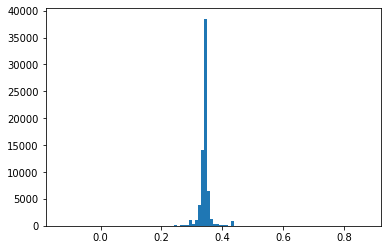

In [705]:
plt.hist(res_np,100)
#plt.xlim([25, 125])
plt.show()

In [706]:
np.mean(res_np) * 100

34.24065113067627

In [707]:
np.median(res_np) * 100

34.37245488166809

In [708]:
np.std(res_np)

0.022394542

# COMPETITION DATA

In [709]:
competition_data = pd.read_csv('./proteindata/test.csv', index_col = False)

In [710]:
competition_data

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
...,...,...,...,...
2408,33798,VPVNPEPDATSVENVILKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2409,33799,VPVNPEPDATSVENVLLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2410,33800,VPVNPEPDATSVENVNLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2411,33801,VPVNPEPDATSVENVPLKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [634]:
x_competition = competition_data['protein_sequence'].tolist()

In [635]:
ph_competition = competition_data['pH'].tolist()

# Dont run the cell below if you have the competition embeddings saved!


In [636]:
x_competition_embed  = []

for i, sequence in enumerate(x_competition):
    print("Working on sequence {}...".format(i))
    embed = ESMembedding(sequence)
    x_competition_embed.append(embed)

Working on sequence 0...
Working on sequence 1...
Working on sequence 2...
Working on sequence 3...
Working on sequence 4...
Working on sequence 5...
Working on sequence 6...
Working on sequence 7...
Working on sequence 8...
Working on sequence 9...
Working on sequence 10...
Working on sequence 11...
Working on sequence 12...
Working on sequence 13...
Working on sequence 14...
Working on sequence 15...
Working on sequence 16...
Working on sequence 17...
Working on sequence 18...
Working on sequence 19...
Working on sequence 20...
Working on sequence 21...
Working on sequence 22...
Working on sequence 23...
Working on sequence 24...
Working on sequence 25...
Working on sequence 26...
Working on sequence 27...
Working on sequence 28...
Working on sequence 29...
Working on sequence 30...
Working on sequence 31...
Working on sequence 32...
Working on sequence 33...
Working on sequence 34...
Working on sequence 35...
Working on sequence 36...
Working on sequence 37...
Working on sequence 38

Working on sequence 312...
Working on sequence 313...
Working on sequence 314...
Working on sequence 315...
Working on sequence 316...
Working on sequence 317...
Working on sequence 318...
Working on sequence 319...
Working on sequence 320...
Working on sequence 321...
Working on sequence 322...
Working on sequence 323...
Working on sequence 324...
Working on sequence 325...
Working on sequence 326...
Working on sequence 327...
Working on sequence 328...
Working on sequence 329...
Working on sequence 330...
Working on sequence 331...
Working on sequence 332...
Working on sequence 333...
Working on sequence 334...
Working on sequence 335...
Working on sequence 336...
Working on sequence 337...
Working on sequence 338...
Working on sequence 339...
Working on sequence 340...
Working on sequence 341...
Working on sequence 342...
Working on sequence 343...
Working on sequence 344...
Working on sequence 345...
Working on sequence 346...
Working on sequence 347...
Working on sequence 348...
W

Working on sequence 617...
Working on sequence 618...
Working on sequence 619...
Working on sequence 620...
Working on sequence 621...
Working on sequence 622...
Working on sequence 623...
Working on sequence 624...
Working on sequence 625...
Working on sequence 626...
Working on sequence 627...
Working on sequence 628...
Working on sequence 629...
Working on sequence 630...
Working on sequence 631...
Working on sequence 632...
Working on sequence 633...
Working on sequence 634...
Working on sequence 635...
Working on sequence 636...
Working on sequence 637...
Working on sequence 638...
Working on sequence 639...
Working on sequence 640...
Working on sequence 641...
Working on sequence 642...
Working on sequence 643...
Working on sequence 644...
Working on sequence 645...
Working on sequence 646...
Working on sequence 647...
Working on sequence 648...
Working on sequence 649...
Working on sequence 650...
Working on sequence 651...
Working on sequence 652...
Working on sequence 653...
W

Working on sequence 923...
Working on sequence 924...
Working on sequence 925...
Working on sequence 926...
Working on sequence 927...
Working on sequence 928...
Working on sequence 929...
Working on sequence 930...
Working on sequence 931...
Working on sequence 932...
Working on sequence 933...
Working on sequence 934...
Working on sequence 935...
Working on sequence 936...
Working on sequence 937...
Working on sequence 938...
Working on sequence 939...
Working on sequence 940...
Working on sequence 941...
Working on sequence 942...
Working on sequence 943...
Working on sequence 944...
Working on sequence 945...
Working on sequence 946...
Working on sequence 947...
Working on sequence 948...
Working on sequence 949...
Working on sequence 950...
Working on sequence 951...
Working on sequence 952...
Working on sequence 953...
Working on sequence 954...
Working on sequence 955...
Working on sequence 956...
Working on sequence 957...
Working on sequence 958...
Working on sequence 959...
W

Working on sequence 1224...
Working on sequence 1225...
Working on sequence 1226...
Working on sequence 1227...
Working on sequence 1228...
Working on sequence 1229...
Working on sequence 1230...
Working on sequence 1231...
Working on sequence 1232...
Working on sequence 1233...
Working on sequence 1234...
Working on sequence 1235...
Working on sequence 1236...
Working on sequence 1237...
Working on sequence 1238...
Working on sequence 1239...
Working on sequence 1240...
Working on sequence 1241...
Working on sequence 1242...
Working on sequence 1243...
Working on sequence 1244...
Working on sequence 1245...
Working on sequence 1246...
Working on sequence 1247...
Working on sequence 1248...
Working on sequence 1249...
Working on sequence 1250...
Working on sequence 1251...
Working on sequence 1252...
Working on sequence 1253...
Working on sequence 1254...
Working on sequence 1255...
Working on sequence 1256...
Working on sequence 1257...
Working on sequence 1258...
Working on sequence 

Working on sequence 1521...
Working on sequence 1522...
Working on sequence 1523...
Working on sequence 1524...
Working on sequence 1525...
Working on sequence 1526...
Working on sequence 1527...
Working on sequence 1528...
Working on sequence 1529...
Working on sequence 1530...
Working on sequence 1531...
Working on sequence 1532...
Working on sequence 1533...
Working on sequence 1534...
Working on sequence 1535...
Working on sequence 1536...
Working on sequence 1537...
Working on sequence 1538...
Working on sequence 1539...
Working on sequence 1540...
Working on sequence 1541...
Working on sequence 1542...
Working on sequence 1543...
Working on sequence 1544...
Working on sequence 1545...
Working on sequence 1546...
Working on sequence 1547...
Working on sequence 1548...
Working on sequence 1549...
Working on sequence 1550...
Working on sequence 1551...
Working on sequence 1552...
Working on sequence 1553...
Working on sequence 1554...
Working on sequence 1555...
Working on sequence 

Working on sequence 1817...
Working on sequence 1818...
Working on sequence 1819...
Working on sequence 1820...
Working on sequence 1821...
Working on sequence 1822...
Working on sequence 1823...
Working on sequence 1824...
Working on sequence 1825...
Working on sequence 1826...
Working on sequence 1827...
Working on sequence 1828...
Working on sequence 1829...
Working on sequence 1830...
Working on sequence 1831...
Working on sequence 1832...
Working on sequence 1833...
Working on sequence 1834...
Working on sequence 1835...
Working on sequence 1836...
Working on sequence 1837...
Working on sequence 1838...
Working on sequence 1839...
Working on sequence 1840...
Working on sequence 1841...
Working on sequence 1842...
Working on sequence 1843...
Working on sequence 1844...
Working on sequence 1845...
Working on sequence 1846...
Working on sequence 1847...
Working on sequence 1848...
Working on sequence 1849...
Working on sequence 1850...
Working on sequence 1851...
Working on sequence 

Working on sequence 2111...
Working on sequence 2112...
Working on sequence 2113...
Working on sequence 2114...
Working on sequence 2115...
Working on sequence 2116...
Working on sequence 2117...
Working on sequence 2118...
Working on sequence 2119...
Working on sequence 2120...
Working on sequence 2121...
Working on sequence 2122...
Working on sequence 2123...
Working on sequence 2124...
Working on sequence 2125...
Working on sequence 2126...
Working on sequence 2127...
Working on sequence 2128...
Working on sequence 2129...
Working on sequence 2130...
Working on sequence 2131...
Working on sequence 2132...
Working on sequence 2133...
Working on sequence 2134...
Working on sequence 2135...
Working on sequence 2136...
Working on sequence 2137...
Working on sequence 2138...
Working on sequence 2139...
Working on sequence 2140...
Working on sequence 2141...
Working on sequence 2142...
Working on sequence 2143...
Working on sequence 2144...
Working on sequence 2145...
Working on sequence 

Working on sequence 2406...
Working on sequence 2407...
Working on sequence 2408...
Working on sequence 2409...
Working on sequence 2410...
Working on sequence 2411...
Working on sequence 2412...


In [637]:
import pickle

with open("competition_embeds_pl_new", "wb") as fp:   #Pickling
    #pickle.dump(x_competition_embed, fp)

# Instead load the saved embeddings!


In [638]:
import pickle
with open("competition_embeds_pl_new", "rb") as fp:
    x_competition_embed = pickle.load(fp)

In [639]:
x_competition[:5]

['VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK',
 'VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPK

In [640]:
x_competition_embed[:5]

[array([-0.05348419, -0.0577033 , -0.15324247, ..., -0.10081477,
         0.00437558,  0.10947983], dtype=float32),
 array([-0.05385044, -0.05386613, -0.16091336, ..., -0.094506  ,
         0.00279988,  0.1078918 ], dtype=float32),
 array([-0.05591825, -0.05563816, -0.15555942, ..., -0.10034766,
         0.00449493,  0.10842798], dtype=float32),
 array([-0.05603744, -0.04441665, -0.15105218, ..., -0.09418205,
        -0.00062137,  0.10995836], dtype=float32),
 array([-0.05250967, -0.04570286, -0.14952633, ..., -0.08603902,
        -0.00391663,  0.11597865], dtype=float32)]

In [642]:
x_competition_embed_new = [x.reshape([1, -1]) for x in x_competition_embed]

In [643]:
x_competition_embed_new2 = np.vstack(x_competition_embed_new)

In [644]:
train_ph_list = np.array(ph_competition).reshape([-1, 1])

In [645]:
train_ph_np_normalized = train_ph_list / 14

In [646]:
x_competition_embed_with_ph = np.hstack([x_competition_embed_new2, train_ph_np_normalized])

In [647]:
x_competition_embed_with_ph.shape

(2413, 1281)

In [648]:
x_competition_embed_with_ph[:5]

array([[-0.05348419, -0.0577033 , -0.15324247, ...,  0.00437558,
         0.10947983,  0.57142857],
       [-0.05385044, -0.05386613, -0.16091336, ...,  0.00279988,
         0.1078918 ,  0.57142857],
       [-0.05591825, -0.05563816, -0.15555942, ...,  0.00449493,
         0.10842798,  0.57142857],
       [-0.05603744, -0.04441665, -0.15105218, ..., -0.00062137,
         0.10995836,  0.57142857],
       [-0.05250967, -0.04570286, -0.14952633, ..., -0.00391663,
         0.11597865,  0.57142857]])

In [736]:
test_index = 1500
embed = x_competition_embed_with_ph[index]
print(embed)
diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embed)
res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)

[-0.05433891 -0.05081803 -0.15671253 ... -0.00171884  0.11399504
  0.57142857]


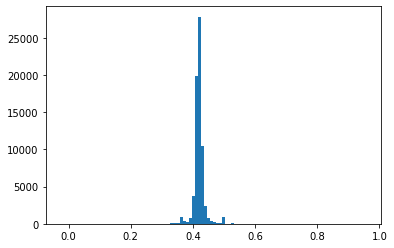

In [737]:
plt.hist(res,100)
#plt.xlim([25, 125])
plt.show()

In [720]:
np.std(res)

0.022394542

In [721]:
np.mean(res) * 100, np.median(res) * 100

(34.24065411090851, 34.37245488166809)

In [722]:
y_competition  = []
modelnn.eval()

for i, embed in enumerate(x_competition_embed_with_ph):
    
    diff, diff_rev, y_arr = getDualRegressionFromEmbedding(embed)
    res = 0.5 * diff_rev - 0.5 * diff + y_arr.reshape(-1,1)
    print("Working on sequence {}... result is {}".format(i, np.median(res)))
    y_competition.append(np.median(res))

Working on sequence 0... result is 0.38408443331718445
Working on sequence 1... result is 0.3970852196216583
Working on sequence 2... result is 0.3970416784286499
Working on sequence 3... result is 0.45854461193084717
Working on sequence 4... result is 0.4486306309700012
Working on sequence 5... result is 0.41870683431625366
Working on sequence 6... result is 0.42405980825424194
Working on sequence 7... result is 0.4330640435218811
Working on sequence 8... result is 0.40260541439056396
Working on sequence 9... result is 0.44550925493240356
Working on sequence 10... result is 0.41402244567871094
Working on sequence 11... result is 0.4116092324256897
Working on sequence 12... result is 0.4056575298309326
Working on sequence 13... result is 0.4126368761062622
Working on sequence 14... result is 0.43112713098526
Working on sequence 15... result is 0.43990403413772583
Working on sequence 16... result is 0.3967703878879547
Working on sequence 17... result is 0.44074153900146484
Working on se

Working on sequence 148... result is 0.3995426893234253
Working on sequence 149... result is 0.4202766418457031
Working on sequence 150... result is 0.39858973026275635
Working on sequence 151... result is 0.4122157096862793
Working on sequence 152... result is 0.3787943422794342
Working on sequence 153... result is 0.4135403037071228
Working on sequence 154... result is 0.39837682247161865
Working on sequence 155... result is 0.4076457619667053
Working on sequence 156... result is 0.38231557607650757
Working on sequence 157... result is 0.3934969902038574
Working on sequence 158... result is 0.41390758752822876
Working on sequence 159... result is 0.3974084258079529
Working on sequence 160... result is 0.39916422963142395
Working on sequence 161... result is 0.39437416195869446
Working on sequence 162... result is 0.3981821537017822
Working on sequence 163... result is 0.38115841150283813
Working on sequence 164... result is 0.4068686366081238
Working on sequence 165... result is 0.40

Working on sequence 294... result is 0.4353250563144684
Working on sequence 295... result is 0.42797592282295227
Working on sequence 296... result is 0.43234044313430786
Working on sequence 297... result is 0.42747536301612854
Working on sequence 298... result is 0.41902613639831543
Working on sequence 299... result is 0.42396044731140137
Working on sequence 300... result is 0.42472100257873535
Working on sequence 301... result is 0.4169917106628418
Working on sequence 302... result is 0.42125174403190613
Working on sequence 303... result is 0.43717628717422485
Working on sequence 304... result is 0.3899729549884796
Working on sequence 305... result is 0.42200639843940735
Working on sequence 306... result is 0.42588791251182556
Working on sequence 307... result is 0.4172821044921875
Working on sequence 308... result is 0.424630343914032
Working on sequence 309... result is 0.42490845918655396
Working on sequence 310... result is 0.4159242510795593
Working on sequence 311... result is 0

Working on sequence 440... result is 0.41230663657188416
Working on sequence 441... result is 0.4034271836280823
Working on sequence 442... result is 0.4212477207183838
Working on sequence 443... result is 0.4110502004623413
Working on sequence 444... result is 0.39021652936935425
Working on sequence 445... result is 0.4116661548614502
Working on sequence 446... result is 0.3958689570426941
Working on sequence 447... result is 0.3972807228565216
Working on sequence 448... result is 0.38879847526550293
Working on sequence 449... result is 0.40733763575553894
Working on sequence 450... result is 0.40906450152397156
Working on sequence 451... result is 0.39638039469718933
Working on sequence 452... result is 0.40674126148223877
Working on sequence 453... result is 0.4219094514846802
Working on sequence 454... result is 0.440215528011322
Working on sequence 455... result is 0.4418601989746094
Working on sequence 456... result is 0.418749064207077
Working on sequence 457... result is 0.4088

Working on sequence 586... result is 0.38979417085647583
Working on sequence 587... result is 0.3906465768814087
Working on sequence 588... result is 0.40372008085250854
Working on sequence 589... result is 0.39933136105537415
Working on sequence 590... result is 0.4052443504333496
Working on sequence 591... result is 0.37445276975631714
Working on sequence 592... result is 0.4049334228038788
Working on sequence 593... result is 0.38474076986312866
Working on sequence 594... result is 0.38271936774253845
Working on sequence 595... result is 0.3937067985534668
Working on sequence 596... result is 0.393596351146698
Working on sequence 597... result is 0.40608644485473633
Working on sequence 598... result is 0.38614174723625183
Working on sequence 599... result is 0.38838499784469604
Working on sequence 600... result is 0.3909141421318054
Working on sequence 601... result is 0.3870968222618103
Working on sequence 602... result is 0.3939790427684784
Working on sequence 603... result is 0.3

Working on sequence 732... result is 0.4108560383319855
Working on sequence 733... result is 0.40107864141464233
Working on sequence 734... result is 0.4012901782989502
Working on sequence 735... result is 0.38875582814216614
Working on sequence 736... result is 0.3972697854042053
Working on sequence 737... result is 0.3923114538192749
Working on sequence 738... result is 0.39330172538757324
Working on sequence 739... result is 0.4077407121658325
Working on sequence 740... result is 0.4117050766944885
Working on sequence 741... result is 0.3962428569793701
Working on sequence 742... result is 0.4359661936759949
Working on sequence 743... result is 0.414236843585968
Working on sequence 744... result is 0.4166784882545471
Working on sequence 745... result is 0.44771361351013184
Working on sequence 746... result is 0.3965153098106384
Working on sequence 747... result is 0.4428180456161499
Working on sequence 748... result is 0.409770667552948
Working on sequence 749... result is 0.4065639

Working on sequence 878... result is 0.42412400245666504
Working on sequence 879... result is 0.3977605700492859
Working on sequence 880... result is 0.4001815915107727
Working on sequence 881... result is 0.4054345488548279
Working on sequence 882... result is 0.41055917739868164
Working on sequence 883... result is 0.409376323223114
Working on sequence 884... result is 0.41035377979278564
Working on sequence 885... result is 0.4147862195968628
Working on sequence 886... result is 0.4289959967136383
Working on sequence 887... result is 0.43788522481918335
Working on sequence 888... result is 0.40553033351898193
Working on sequence 889... result is 0.4131823778152466
Working on sequence 890... result is 0.4345960021018982
Working on sequence 891... result is 0.416878879070282
Working on sequence 892... result is 0.39384108781814575
Working on sequence 893... result is 0.4038509130477905
Working on sequence 894... result is 0.4173427224159241
Working on sequence 895... result is 0.39740

Working on sequence 1023... result is 0.3898858428001404
Working on sequence 1024... result is 0.39237138628959656
Working on sequence 1025... result is 0.3860456645488739
Working on sequence 1026... result is 0.40428540110588074
Working on sequence 1027... result is 0.4360581934452057
Working on sequence 1028... result is 0.417521595954895
Working on sequence 1029... result is 0.4194030165672302
Working on sequence 1030... result is 0.4092895984649658
Working on sequence 1031... result is 0.402376651763916
Working on sequence 1032... result is 0.44783154129981995
Working on sequence 1033... result is 0.42393866181373596
Working on sequence 1034... result is 0.4107634425163269
Working on sequence 1035... result is 0.38974928855895996
Working on sequence 1036... result is 0.39726823568344116
Working on sequence 1037... result is 0.40306952595710754
Working on sequence 1038... result is 0.40548115968704224
Working on sequence 1039... result is 0.40503445267677307
Working on sequence 1040

Working on sequence 1166... result is 0.43052566051483154
Working on sequence 1167... result is 0.40790727734565735
Working on sequence 1168... result is 0.43541619181632996
Working on sequence 1169... result is 0.4022866487503052
Working on sequence 1170... result is 0.42621850967407227
Working on sequence 1171... result is 0.4392239451408386
Working on sequence 1172... result is 0.43089503049850464
Working on sequence 1173... result is 0.4308176338672638
Working on sequence 1174... result is 0.4456726908683777
Working on sequence 1175... result is 0.4373295307159424
Working on sequence 1176... result is 0.40261438488960266
Working on sequence 1177... result is 0.41453322768211365
Working on sequence 1178... result is 0.41185659170150757
Working on sequence 1179... result is 0.409718781709671
Working on sequence 1180... result is 0.39751726388931274
Working on sequence 1181... result is 0.41834330558776855
Working on sequence 1182... result is 0.41896843910217285
Working on sequence 1

Working on sequence 1309... result is 0.42188602685928345
Working on sequence 1310... result is 0.40474650263786316
Working on sequence 1311... result is 0.39967966079711914
Working on sequence 1312... result is 0.3971947133541107
Working on sequence 1313... result is 0.3982788324356079
Working on sequence 1314... result is 0.3880138695240021
Working on sequence 1315... result is 0.3976174294948578
Working on sequence 1316... result is 0.3969816267490387
Working on sequence 1317... result is 0.4092474579811096
Working on sequence 1318... result is 0.40489447116851807
Working on sequence 1319... result is 0.40802544355392456
Working on sequence 1320... result is 0.39475196599960327
Working on sequence 1321... result is 0.40398970246315
Working on sequence 1322... result is 0.3943782448768616
Working on sequence 1323... result is 0.40348702669143677
Working on sequence 1324... result is 0.4149555563926697
Working on sequence 1325... result is 0.3892263174057007
Working on sequence 1326..

Working on sequence 1452... result is 0.39123809337615967
Working on sequence 1453... result is 0.39478588104248047
Working on sequence 1454... result is 0.38721466064453125
Working on sequence 1455... result is 0.4056498110294342
Working on sequence 1456... result is 0.39720043540000916
Working on sequence 1457... result is 0.4017689526081085
Working on sequence 1458... result is 0.40573614835739136
Working on sequence 1459... result is 0.3853945732116699
Working on sequence 1460... result is 0.3939272165298462
Working on sequence 1461... result is 0.4006975591182709
Working on sequence 1462... result is 0.3947158455848694
Working on sequence 1463... result is 0.40674203634262085
Working on sequence 1464... result is 0.4008200168609619
Working on sequence 1465... result is 0.39993345737457275
Working on sequence 1466... result is 0.3974630832672119
Working on sequence 1467... result is 0.403830885887146
Working on sequence 1468... result is 0.4166461229324341
Working on sequence 1469.

Working on sequence 1595... result is 0.3988572955131531
Working on sequence 1596... result is 0.4029688239097595
Working on sequence 1597... result is 0.4133765697479248
Working on sequence 1598... result is 0.41820377111434937
Working on sequence 1599... result is 0.41265225410461426
Working on sequence 1600... result is 0.4100666642189026
Working on sequence 1601... result is 0.394614577293396
Working on sequence 1602... result is 0.40868574380874634
Working on sequence 1603... result is 0.40186572074890137
Working on sequence 1604... result is 0.3913077712059021
Working on sequence 1605... result is 0.38751721382141113
Working on sequence 1606... result is 0.4027899503707886
Working on sequence 1607... result is 0.39779844880104065
Working on sequence 1608... result is 0.4008290767669678
Working on sequence 1609... result is 0.3788650631904602
Working on sequence 1610... result is 0.3958349823951721
Working on sequence 1611... result is 0.3969367444515228
Working on sequence 1612..

Working on sequence 1738... result is 0.39979714155197144
Working on sequence 1739... result is 0.39476045966148376
Working on sequence 1740... result is 0.4050661623477936
Working on sequence 1741... result is 0.39801764488220215
Working on sequence 1742... result is 0.39603862166404724
Working on sequence 1743... result is 0.39317870140075684
Working on sequence 1744... result is 0.4082353115081787
Working on sequence 1745... result is 0.403261661529541
Working on sequence 1746... result is 0.385391503572464
Working on sequence 1747... result is 0.40231889486312866
Working on sequence 1748... result is 0.4014393091201782
Working on sequence 1749... result is 0.38969817757606506
Working on sequence 1750... result is 0.38044437766075134
Working on sequence 1751... result is 0.4030466675758362
Working on sequence 1752... result is 0.38820725679397583
Working on sequence 1753... result is 0.39772292971611023
Working on sequence 1754... result is 0.3929140567779541
Working on sequence 175

Working on sequence 1881... result is 0.4298694431781769
Working on sequence 1882... result is 0.43053266406059265
Working on sequence 1883... result is 0.3974318504333496
Working on sequence 1884... result is 0.42362475395202637
Working on sequence 1885... result is 0.42845016717910767
Working on sequence 1886... result is 0.42717453837394714
Working on sequence 1887... result is 0.42381107807159424
Working on sequence 1888... result is 0.39837130904197693
Working on sequence 1889... result is 0.3974720239639282
Working on sequence 1890... result is 0.40206241607666016
Working on sequence 1891... result is 0.3985412120819092
Working on sequence 1892... result is 0.40183740854263306
Working on sequence 1893... result is 0.4005996286869049
Working on sequence 1894... result is 0.40217670798301697
Working on sequence 1895... result is 0.4004843831062317
Working on sequence 1896... result is 0.3869439959526062
Working on sequence 1897... result is 0.4018489420413971
Working on sequence 18

Working on sequence 2024... result is 0.42204779386520386
Working on sequence 2025... result is 0.41956454515457153
Working on sequence 2026... result is 0.4003267288208008
Working on sequence 2027... result is 0.41624781489372253
Working on sequence 2028... result is 0.41012299060821533
Working on sequence 2029... result is 0.43773096799850464
Working on sequence 2030... result is 0.4307023286819458
Working on sequence 2031... result is 0.3995739221572876
Working on sequence 2032... result is 0.3965544104576111
Working on sequence 2033... result is 0.3902169466018677
Working on sequence 2034... result is 0.3997851014137268
Working on sequence 2035... result is 0.4081825017929077
Working on sequence 2036... result is 0.4086591303348541
Working on sequence 2037... result is 0.4090697169303894
Working on sequence 2038... result is 0.40571609139442444
Working on sequence 2039... result is 0.3954036235809326
Working on sequence 2040... result is 0.41294699907302856
Working on sequence 2041

Working on sequence 2167... result is 0.4089680016040802
Working on sequence 2168... result is 0.38663196563720703
Working on sequence 2169... result is 0.40366625785827637
Working on sequence 2170... result is 0.4222245216369629
Working on sequence 2171... result is 0.3912689685821533
Working on sequence 2172... result is 0.4017568826675415
Working on sequence 2173... result is 0.40592822432518005
Working on sequence 2174... result is 0.4191098213195801
Working on sequence 2175... result is 0.3982284665107727
Working on sequence 2176... result is 0.4063226580619812
Working on sequence 2177... result is 0.40357697010040283
Working on sequence 2178... result is 0.42334115505218506
Working on sequence 2179... result is 0.406008780002594
Working on sequence 2180... result is 0.4118867516517639
Working on sequence 2181... result is 0.4267435073852539
Working on sequence 2182... result is 0.4041624069213867
Working on sequence 2183... result is 0.4335457980632782
Working on sequence 2184...

Working on sequence 2310... result is 0.4229607582092285
Working on sequence 2311... result is 0.40104353427886963
Working on sequence 2312... result is 0.403222918510437
Working on sequence 2313... result is 0.3871912956237793
Working on sequence 2314... result is 0.41336333751678467
Working on sequence 2315... result is 0.40750861167907715
Working on sequence 2316... result is 0.41205841302871704
Working on sequence 2317... result is 0.39607542753219604
Working on sequence 2318... result is 0.4232611358165741
Working on sequence 2319... result is 0.4198024868965149
Working on sequence 2320... result is 0.402447372674942
Working on sequence 2321... result is 0.41431182622909546
Working on sequence 2322... result is 0.44257596135139465
Working on sequence 2323... result is 0.4368501901626587
Working on sequence 2324... result is 0.40171539783477783
Working on sequence 2325... result is 0.41345715522766113
Working on sequence 2326... result is 0.39080435037612915
Working on sequence 232

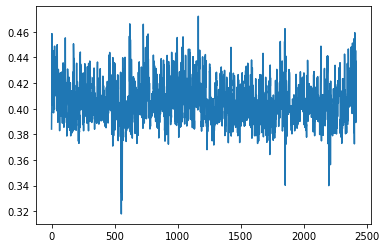

In [724]:
plt.plot(y_competition)

In [725]:
competition_tm = [100 * y for y in y_competition]

In [726]:
submission = pd.read_csv("./proteindata/sample_submission.csv")

In [727]:
submission

,seq_id,tm
0,31390,0
1,31391,1
2,31392,2
3,31393,3
4,31394,4
...,...,...
2408,33798,2408
2409,33799,2409
2410,33800,2410
2411,33801,2411


In [728]:
competition_tm_round = [round(x, 1) for x in competition_tm]
competition_tm_round

[38.4,
 39.7,
 39.7,
 45.9,
 44.9,
 41.9,
 42.4,
 43.3,
 40.3,
 44.6,
 41.4,
 41.2,
 40.6,
 41.3,
 43.1,
 44.0,
 39.7,
 44.1,
 42.1,
 40.5,
 41.9,
 40.7,
 40.0,
 40.0,
 44.9,
 41.7,
 41.9,
 42.0,
 44.0,
 42.0,
 42.8,
 43.1,
 41.3,
 43.6,
 43.0,
 42.8,
 43.1,
 41.7,
 41.0,
 44.1,
 41.6,
 41.7,
 43.5,
 39.8,
 40.8,
 45.0,
 41.8,
 40.8,
 41.4,
 41.8,
 38.9,
 42.0,
 41.2,
 41.9,
 43.1,
 41.9,
 42.8,
 39.5,
 39.2,
 40.2,
 40.2,
 41.0,
 39.5,
 39.5,
 38.3,
 40.0,
 41.0,
 41.0,
 40.7,
 42.8,
 42.3,
 42.1,
 42.8,
 41.3,
 41.2,
 42.6,
 41.6,
 39.4,
 39.5,
 39.8,
 42.9,
 40.0,
 41.7,
 39.6,
 39.8,
 39.5,
 38.9,
 40.7,
 40.4,
 41.7,
 42.2,
 43.5,
 43.6,
 41.6,
 39.0,
 43.1,
 41.0,
 39.6,
 38.6,
 40.2,
 42.9,
 41.9,
 43.4,
 42.9,
 41.9,
 43.2,
 41.2,
 42.3,
 41.2,
 45.5,
 42.4,
 42.1,
 41.9,
 39.4,
 42.0,
 40.7,
 40.6,
 39.8,
 39.4,
 38.9,
 39.6,
 37.9,
 39.1,
 40.2,
 40.3,
 40.6,
 41.6,
 43.1,
 42.8,
 42.5,
 41.6,
 40.6,
 40.7,
 40.8,
 41.9,
 41.0,
 41.3,
 38.6,
 39.5,
 39.9,
 42.4,
 39.7,
 39.9,

In [729]:
submission['tm'] = competition_tm_round

In [730]:
filename_submission = "./proteindata/submission_0101_v2.csv"

In [731]:
submission.to_csv(filename_submission, index = False)

In [732]:
!kaggle competitions submit -c novozymes-enzyme-stability-prediction -f "./proteindata/submission_0101_v2.csv" -m Stra_DualReg

Successfully submitted to Novozymes Enzyme Stability Prediction



  0%|          | 0.00/28.3k [00:00<?, ?B/s]
100%|##########| 28.3k/28.3k [00:02<00:00, 11.6kB/s]


In [733]:
!kaggle competitions submissions -c novozymes-enzyme-stability-prediction 

fileName                          date                 description    status    publicScore  privateScore  
--------------------------------  -------------------  -------------  --------  -----------  ------------  
submission_0101_v2.csv            2023-01-02 00:51:37  Stra_DualReg   complete  0.012                      
submission_kNN_new_E.csv          2023-01-01 10:43:36  Stra_DualReg   complete  0.046                      
submission_kNN_new.csv            2023-01-01 10:36:29  Stra_DualReg   complete  0.008                      
submission_dualRegp12.csv         2023-01-01 10:32:30  Stra_DualReg   complete  -0.023                     
submission_dualRegp10.csv         2022-12-31 23:22:33  Stra_DualReg   complete  -0.027                     
submission_dualReg6.csv           2022-12-31 12:32:41  Stra_DualReg   complete  -0.166                     
submission_dualReg5.csv           2022-12-31 09:01:22  Stra_DualReg   complete  0.016                      
submission_dualReg4.csv     